## Load data and library

In [1]:
%run functions

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
loader = DataLoader()
d = loader.GetData('final')

In [3]:
clean_text = []
preproc = preprocessing.make_pipeline(preprocessing.normalize.whitespace)
for essay in d['text']:
    for punct in [':',',','.','?',';',"'",'!']:
        essay = essay.replace(punct,punct+' ')
    cleaned = preproc(essay.replace('\n',''))
    clean_text.append(cleaned)
d['text'] = clean_text

In [4]:
d.loc[:,'level'] = 0
percentiles = []
for i in range(10,100,10):
    percentiles.append(np.percentile(d['score'],i))
d.loc[d['score'] <= percentiles[0],'level'] = '100'
for i in range(8):
    d.loc[(d['score'] <= percentiles[i+1]) & (d['score'] > percentiles[i]),'level'] = str((10-i-1)*10)
d.loc[d['score'] > percentiles[-1],'level'] = '10'
d = d.loc[d['score'] > 0]
#d = d[d['Prompt'] == 19121438]
#d = d[d['任课教师'].isin(['1002658413(白静远)','1002658414(薛清)','1002658415(谢怡沁)'])]

### VAC list

In [5]:
with open('features/final-verbvac.txt',encoding='utf-8') as f:
    vac_docs =f.readlines()

In [6]:
counts = dict()
for l in vac_docs:
    for v in l.rstrip('\n').replace('(','_').replace(')','_').replace('?','_').split(', '):
        if v in counts:
            counts[v] += 1
        else:
            counts[v] = 1

In [7]:
sorted([(v,counts[v]) for v in counts.keys()],key= lambda x:x[1],reverse=True)

[('be_adj', 8887),
 ('be_noun_attr_', 8788),
 ('have_noun_dobj_', 4449),
 ('read_noun_dobj_', 3027),
 ('make_noun_dobj_', 2782),
 ('learn_noun_dobj_', 2437),
 ('expl_be_', 1784),
 ('improve_noun_dobj_', 1579),
 ('make_noun_subj__v2', 1533),
 ('do_noun_dobj_', 1460),
 ('live_vi_prep', 1360),
 ('help_noun_subj__v2', 1160),
 ('keep_adj', 1150),
 ('s_noun_attr_', 1142),
 ('read_vi', 1012),
 ('take_noun_dobj_', 1000),
 ('want_to_v2', 930),
 ('find_noun_dobj_', 866),
 ('be_prep', 856),
 ('build_noun_dobj_', 854),
 ('overcome_noun_dobj_', 850),
 ('like_noun_dobj_', 837),
 ('need_to_v2', 834),
 ('get_noun_dobj_', 834),
 ('play_noun_dobj_', 754),
 ('be_to_do', 748),
 ('try_to_v2', 733),
 ('be_that', 728),
 ('go_vi', 721),
 ('use_noun_dobj_', 698),
 ('let_noun_subj__v2', 695),
 ('keep_noun_dobj_', 693),
 ('talk_vi_prep', 681),
 ('s_adj', 672),
 ("'_vi", 661),
 ('become_adj', 644),
 ('feel_adj', 626),
 ('think_cl_obj_', 606),
 ('give_noun_dobj__dative', 604),
 ('make_noun_subj__adj', 588),
 ('go_

In [8]:
stop = [i for i in counts.keys() if 'keep_' in i or 'read_' in i or 'learn_' in i or 'other_' in i  or 'play_' in i  or 'live_' in i  or 'improve_' in i or 'build_' in i or 'meet_' in i or 'miss_' in i or 'addict_' in i or 'eat_' in i]

## LSA
### TF-IDF encodings for vac

In [9]:
vector = TfidfVectorizer(max_features=3000,tokenizer=None,stop_words=stop)
#
features = vector.fit_transform([vac_docs[d.index[i]].rstrip('\n').replace('(','_').replace(')','_').replace('?','_').replace('s_','be_') for i in range(len(d.index))])

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['give_', 'hear', 'importantly', 'it_is___that', 'it_is___to_addict_', 'it_is___to_build_', 'it_is___to_cheat_', 'it_is___to_creat_', 'it_is___to_eat_', 'it_is___to_improve_', 'it_is___to_keep_', 'it_is___to_learn_', 'it_is___to_live_', 'it_is___to_meet_', 'it_is___to_miss_', 'it_is___to_play_', 'it_is___to_read_', 'it_is___to_treat_', 'last', 'life', 'only_aux_learn_inv', 'only_prep_aux_build_inv', 'only_prep_aux_improve_inv', 'only_prep_aux_keep_inv', 'only_prep_aux_learn_inv', 'only_prep_aux_live_inv', 'only_prep_aux_meet_inv', 'only_prep_aux_play_inv', 'only_prep_aux_read_inv', 'other_', 'other_altought_', 'other_iivng_', 'other_suggested', 'other_to', 'practice_', 'speak', 'who_build_', 'who_improve_', 'who_keep_', 'who_learn_', 'who_live_', 'who_meet_', '

In [10]:
svd = TruncatedSVD(10)
features = svd.fit_transform(features)

## Plot clustering results
### Set color labels

In [11]:
sns.color_palette("hls",10)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6207999999999999)]

In [12]:
colors= dict()
count = 0
for i in list(d['Prompt']):
    if not i in colors:
        colors[i] = sns.color_palette("hls",10)[count]
        count += 1
label_color = [colors[d['Prompt'][i]] for i in d.index]

### Hierarchy clustering

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


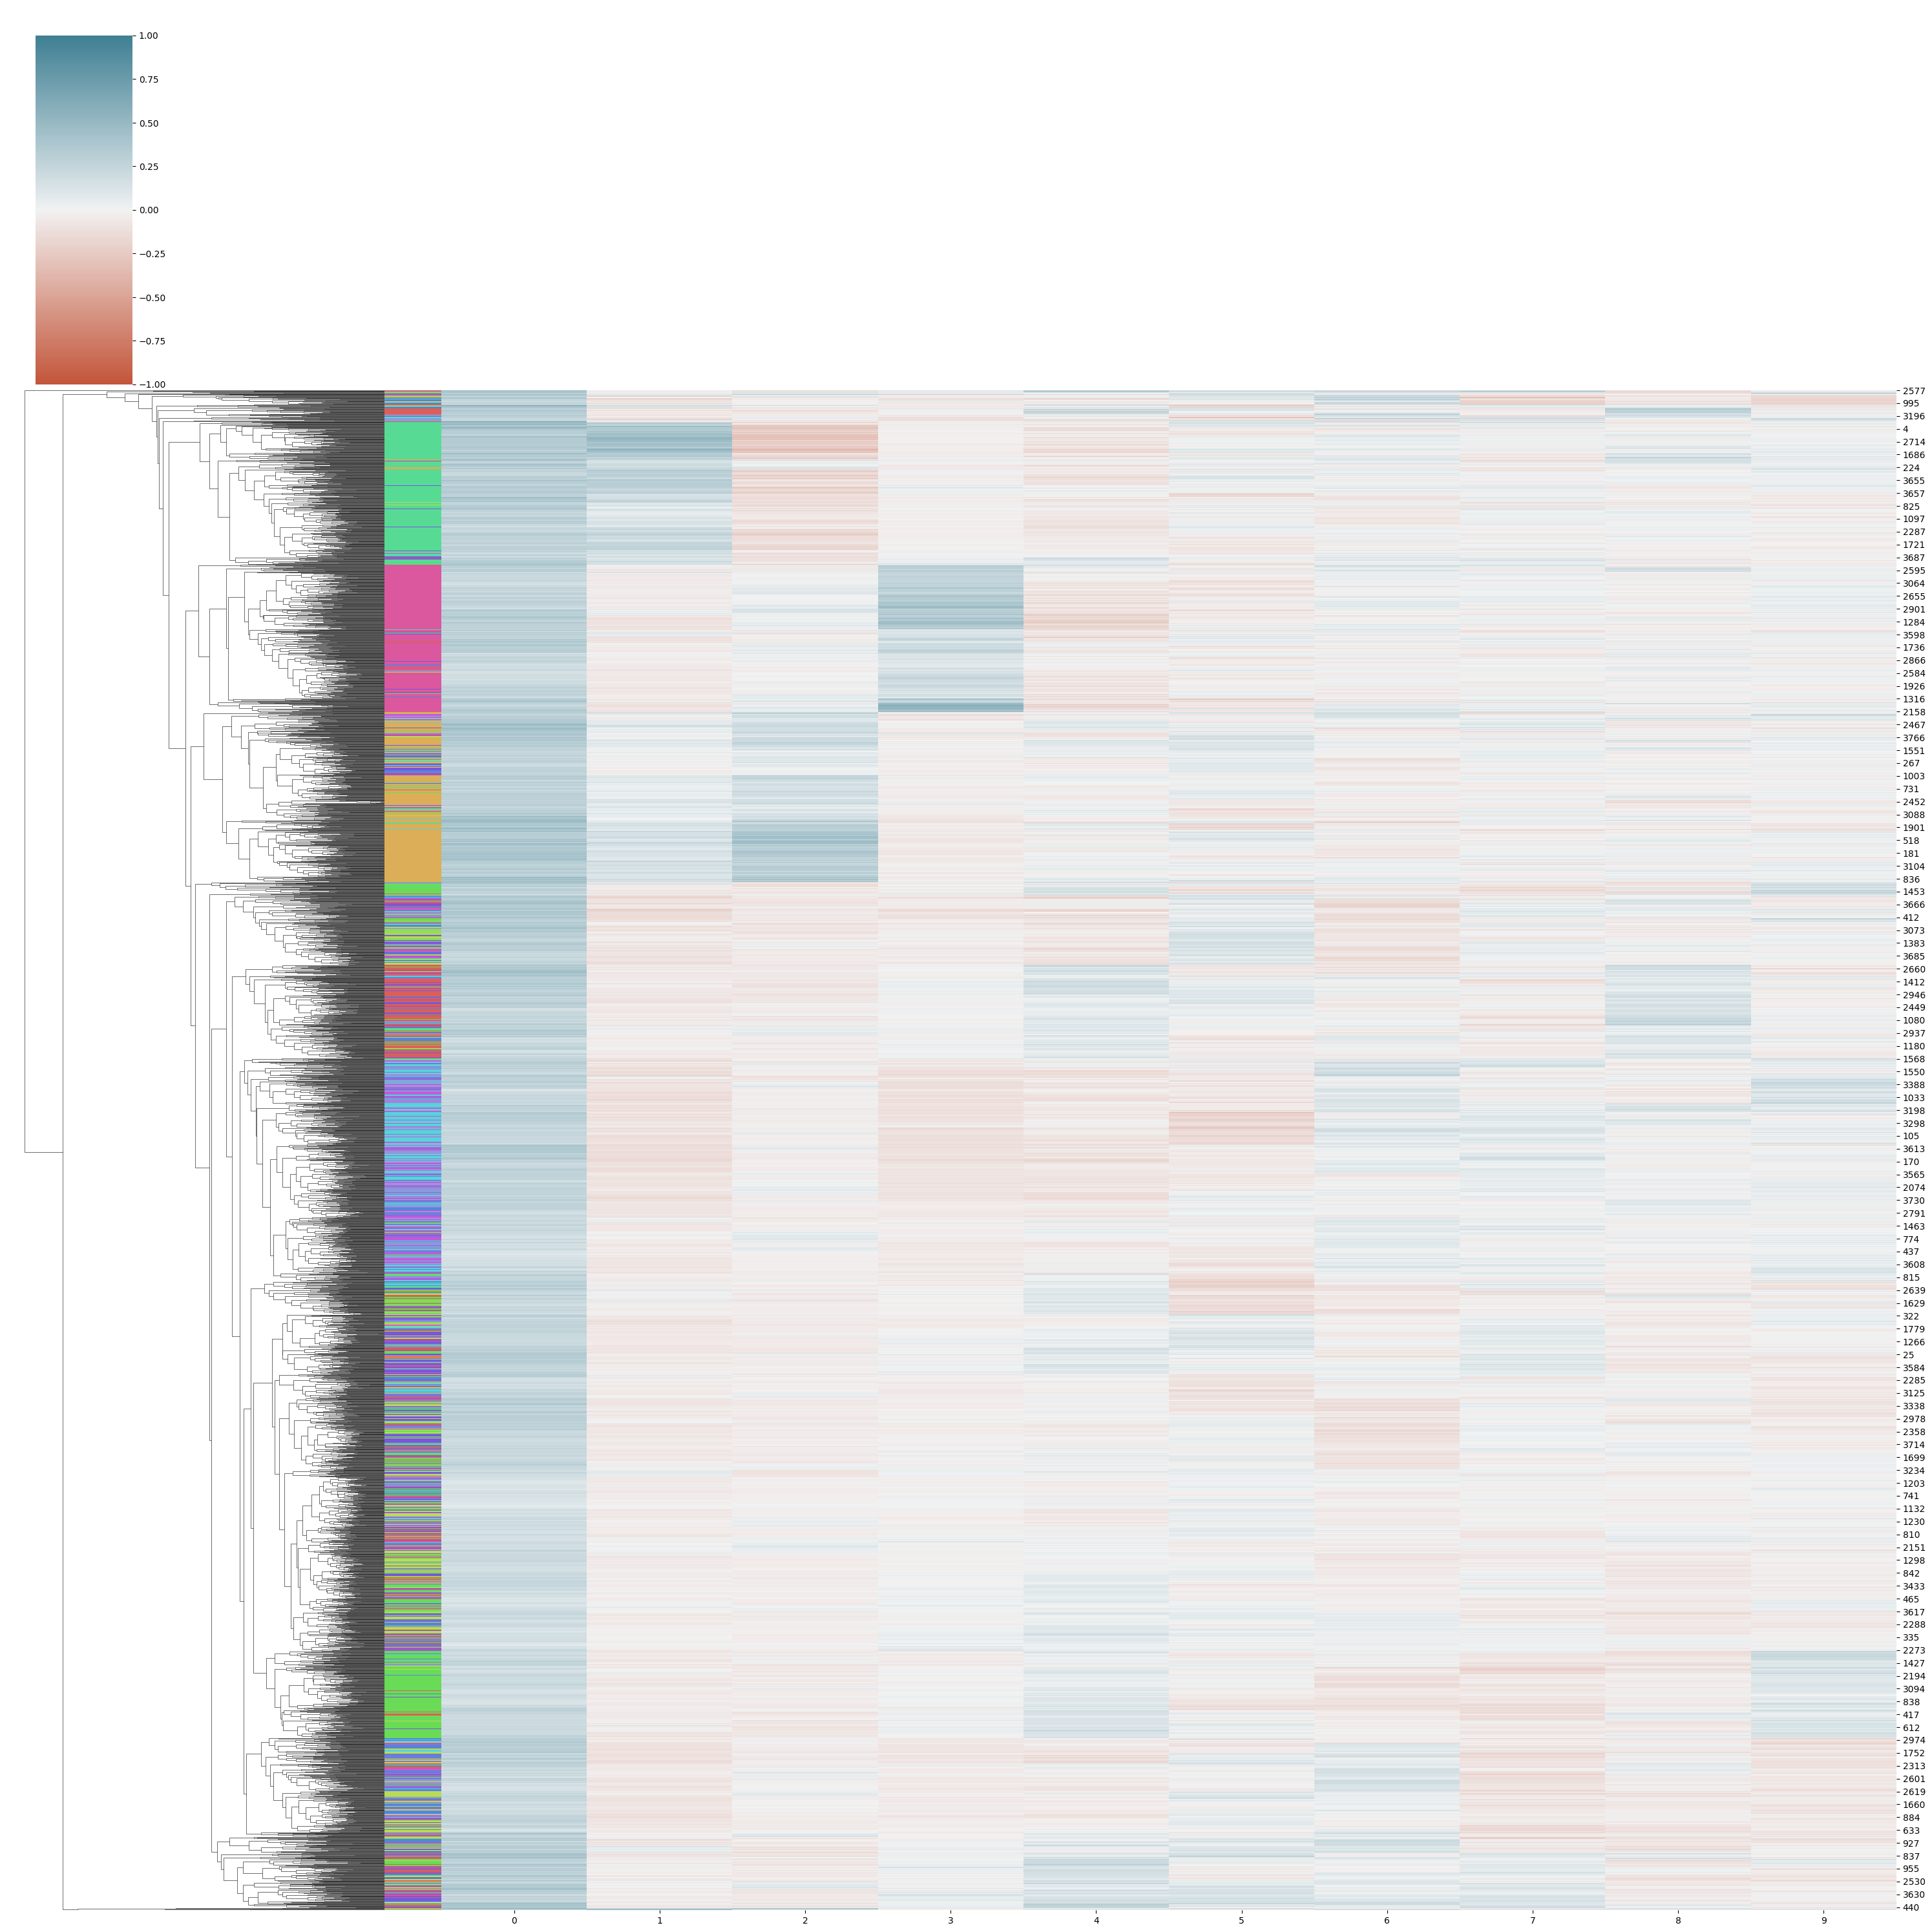

In [13]:
cmap = sns.diverging_palette(20, 220, as_cmap=True)
sns.clustermap(features,figsize = (30,30),vmin=-1,vmax=1,center=0,cmap=cmap,row_colors=label_color,col_cluster=False)

In [40]:
sim = cosine_similarity(features)

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


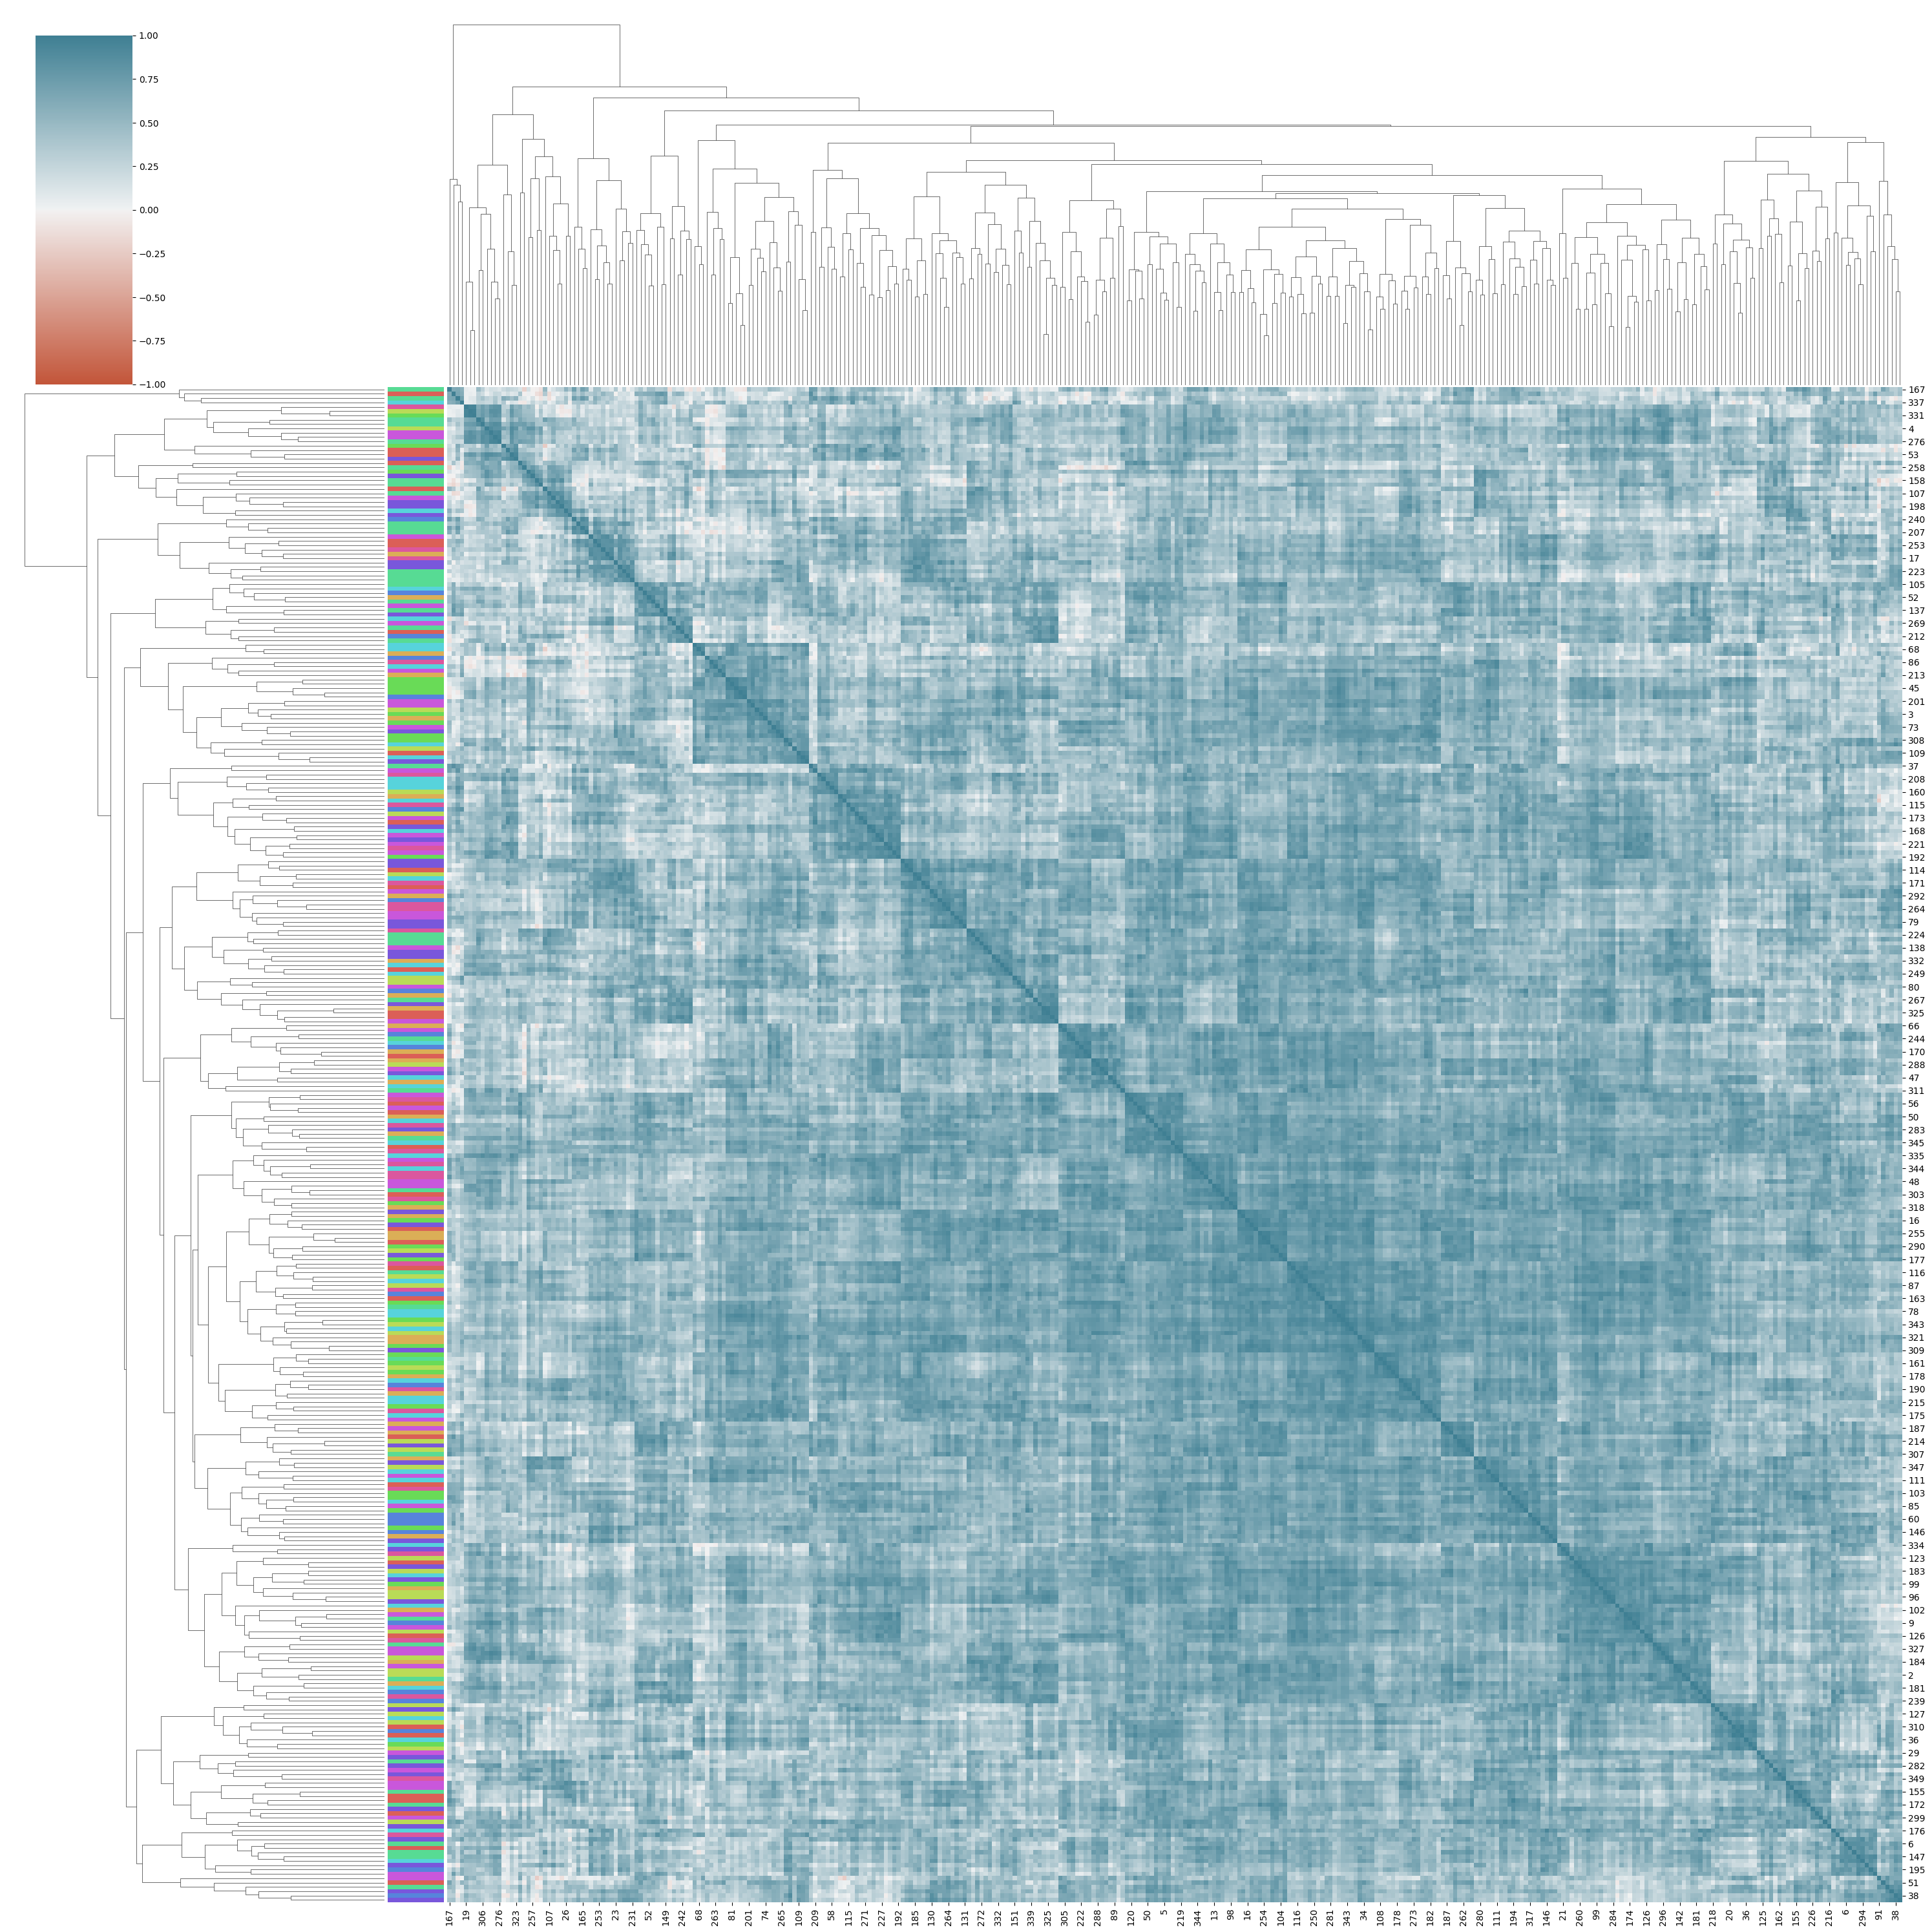

In [41]:
sns.clustermap(sim,figsize = (30,30),vmin=-1,vmax=1,center=0,cmap=cmap,row_colors=label_color)

### T-SNE for visualization

In [16]:
vis = TSNE()
pos = vis.fit_transform(features)

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


### K-means clustering

In [16]:
cluster_model = SpectralClustering(10,affinity='precomputed')
#cluster_model = KMeans(10)
cluster_labels = cluster_model.fit_predict(sim)

In [86]:
d['label'] = [str(i)  for i in cluster_labels]

C:\Users\GIGA\AppData\Local\Temp\ipykernel_11308\4274928752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['label'] = [str(i)  for i in cluster_labels]


In [87]:
for i in range(10):
    print(d[d['label'] == str(i)]['Prompt'].astype('str').describe()['top'])

19121440
19121413
19121439
19121435
19121438
1000561535
19121435
19121416
19121437
19121436


In [88]:
print(d[d['Prompt'] == 19121435]['label'].describe()['top'])

6


In [89]:
cluster_true = {19121438: 4,
 19121435: 6,
 19121440: 0,
 1000561535: 5,
 19121437: 8,
 19121436: 9,
 19121416: 7,
 19121413: 1,
 19121417: 3,
 19121439: 2}

In [90]:
clusters = cluster_true.copy()
for name in cluster_true:
    clu = [i for i in range(len(cluster_labels)) if cluster_labels[i] == cluster_true[name]]
    clusters[name] = clu

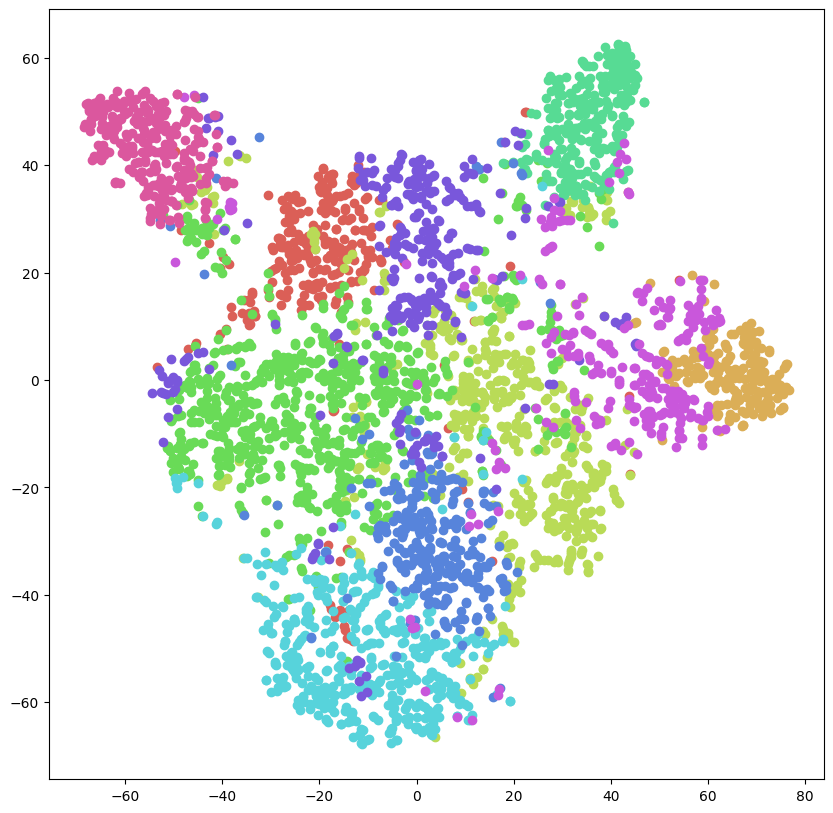

In [91]:
ax = plt.subplots(1,1,figsize = (10,10))
for clu in clusters:
    x = []
    y = []
    for i in clusters[clu]:
        x.append(pos[i, 0])
        y.append(pos[i,1])
    plt.scatter(x,y,color = colors[clu],label = clu)
    #plt.legend(loc='best')

### Plot true labels

In [17]:
true_labels = list(d['Prompt'])
clusters = dict([(Cluster_name,[]) for Cluster_name in d['Prompt']])
for i in range(len(true_labels)):
    if true_labels[i] in clusters:
        clusters[true_labels[i]].append(i)
    else:
        clusters[true_labels[i]] = [i]
c = [tuple(clusters[i]) for i in clusters]

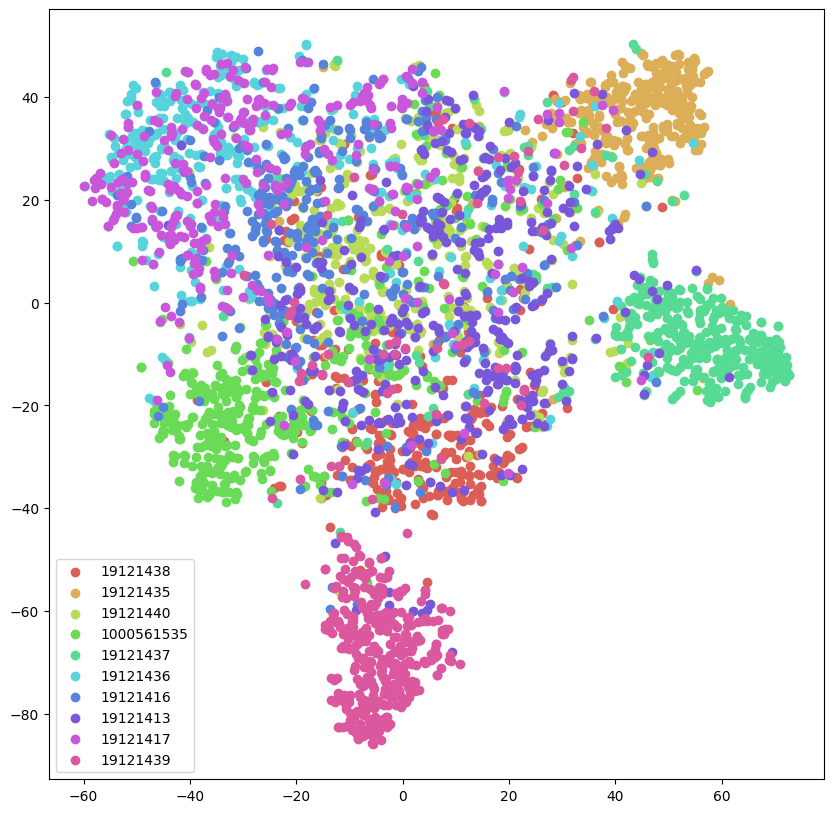

In [18]:
ax = plt.subplots(1,1,figsize = (10,10))
for clu in clusters:
    x = []
    y = []
    for i in clusters[clu]:
        x.append(pos[i, 0])
        y.append(pos[i,1])
    plt.scatter(x,y,color = colors[clu],label = clu)
    plt.legend(loc='best')

### Table for most important VACs

In [35]:
dictionary = vector.get_feature_names_out()
topic_values = []
for t in svd.components_:
    values = [(dictionary[i],t[i]) for i in range(len(t))]
    topic_values.append(sorted(values,key=lambda x:x[1],reverse=True))
for v in topic_values:
    for vac in v[:3]+v[-3:]:
        print('{}'.format(vac[0]),end=', ')
    print('')
    for vac in v[:3]+v[-3:]:
        print('{:.2f}'.format(vac[1]),end=', ')
    print('')

be_noun_attr_, be_adj, have_noun_dobj_, allow_noun_dobj_, passive_free_, slide_noun_dobj_, 
0.46, 0.46, 0.28, 0.00, 0.00, 0.00, 
like_noun_dobj_, make_noun_subj__v2, make_noun_dobj_, use_noun_dobj_, expl_be_, be_noun_attr_, 
0.62, 0.41, 0.34, -0.12, -0.15, -0.23, 
make_noun_dobj_, share_noun_dobj_, find_noun_dobj_, be_noun_attr_, make_noun_subj__v2, like_noun_dobj_, 
0.81, 0.08, 0.07, -0.11, -0.27, -0.37, 
overcome_noun_dobj_, misbe_noun_dobj_, leave_noun_dobj_, speak_vi, use_noun_dobj_, be_noun_attr_, 
0.75, 0.25, 0.20, -0.10, -0.12, -0.15, 
have_noun_dobj_, do_noun_dobj_, be_adj, like_noun_dobj_, overcome_noun_dobj_, be_noun_attr_, 
0.55, 0.27, 0.21, -0.21, -0.28, -0.38, 
be_noun_attr_, have_noun_dobj_, expl_be_, overcome_noun_dobj_, speak_vi, be_adj, 
0.40, 0.32, 0.20, -0.13, -0.14, -0.64, 
help_noun_subj__v2, have_noun_dobj_, need_to_v2, expl_be_, be_noun_attr_, be_adj, 
0.40, 0.35, 0.18, -0.23, -0.27, -0.27, 
have_noun_dobj_, speak_vi, be_noun_attr_, become_adj, get_noun_dobj_, he

### A few examples

In [54]:
LSAGroup = []
for i in range(3784):
    group = np.argmax(np.abs(features[i][1:]))
    LSAGroup.append(group)
d['Group'] = LSAGroup

C:\Users\GIGA\AppData\Local\Temp\ipykernel_13784\2946666749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Group'] = LSAGroup


In [63]:
d[d['Group'] == 5]['Prompt'].astype(str).describe()

count            486
unique            10
top       1000561535
freq              84
Name: Prompt, dtype: object

In [90]:
exp = []
for i in d[d['Group'] == 5].index:
    VACs = GetVAC(d['text'][i],render=False)
    mark1,mark2 = False,True
    for v in VACs:
        if 'want_to_v2' in v[0]:
            mark1 = True
    for v in VACs:
        if 'be_noun(attr)' in v[0] or 'need_to_v2' in v[0]:
            mark2 = False
    if mark1 and mark2:
        doc = NLP(d['text'][i])
        print(i)

266
412
934
1227
1254
2148
2706
2823
3070


In [4]:
with open('features/final-winter-dep.txt') as f:
    essay_in_sent =f.readlines()

In [5]:
cttr = []
for i in range(len(essay_in_sent)):
    txt = essay_in_sent[i].split(', ')
    count = 1
    sttr = 0
    if len(txt) < 50:
        typec = len(set(txt[:len(txt)]))
        ttr = typec/len(txt)
        sttr += ttr
        cttr.append(sttr)
        continue
    for num in range(len(txt) // 50):
        typec = len(set(txt[num*50:(num+1)*50]))
        ttr = typec/50
        sttr += ttr
        count += 1
    typec = len(set(txt[len(txt) // 50 * 50:len(txt)]))
    ttr = typec/(len(txt) -( len(txt) // 50 * 50)+ 1)
    sttr += ttr
    cttr.append(sttr/(count + 1))

In [8]:
d['cttr'] = cttr

In [9]:
d = d[d['score'] > 0]

In [11]:
pg.linear_regression(d['cttr'],d['score'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,8.289103,0.206242,40.191194,1.974185e-294,0.020644,0.020385,7.884747,8.693459
1,cttr,5.148060,0.576577,8.928659,6.593450e-19,0.020644,0.020385,4.017628,6.278492


In [6]:
cttr = [cttr[i] for i in range(len(cttr)) if i in d.index]

In [544]:
TrainX,TestX = np.array(cttr[:2500]).reshape(2500,1),np.array(cttr[2500:]).reshape(1284,1)

In [501]:
TrainX,TestX = features[:2500],features[2500:]

In [545]:
TrainY,TestY = d.loc[d.index[:2500],'score'],d.loc[d.index[2500:],'score']

In [546]:
model = linear_model.Ridge()
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)

In [547]:
explained_variance_score(TestY,PredY)

0.006236530893359737

In [474]:
mean_squared_error(TestY,PredY,squared = False)

1.331491583162773

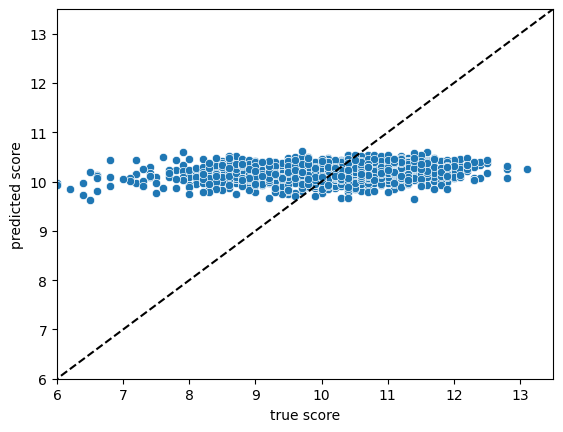

In [548]:
g = sns.scatterplot(x=TestY,y=PredY)
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((6,13.5))
g.set_xlim((6,13.5))
g = sns.lineplot(x=[0,13.5],y=[0,13.5],color='black')
g.lines[0].set_linestyle("--")